In this tutorial, I will
1. Extract characteristic images from the image dataset using principal component analysis
2. Use the set of characteristic images to create a weight vector for any seen or unseen images
3. Use the weight vectors of different images to measure for their similarity, and apply this technique to face recognition
4. Reconstruct original images using the obtained PCA
5. Generate a new random image from the characteristic images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import zipfile
import os

In [ ]:
from google.colab import files
upload = files.upload()

Saving facesDF.zip to facesDF (1).zip


In [ ]:
## This deals with how to read a particular format
## of files from a zip file recursively

## Read face image from zip file on the fly
faces = {}

with zipfile.ZipFile("facesDF.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8),
                                           cv2.IMREAD_GRAYSCALE)


In [ ]:
len(faces) ## 40 people with 10 images

400

Showing sample faces


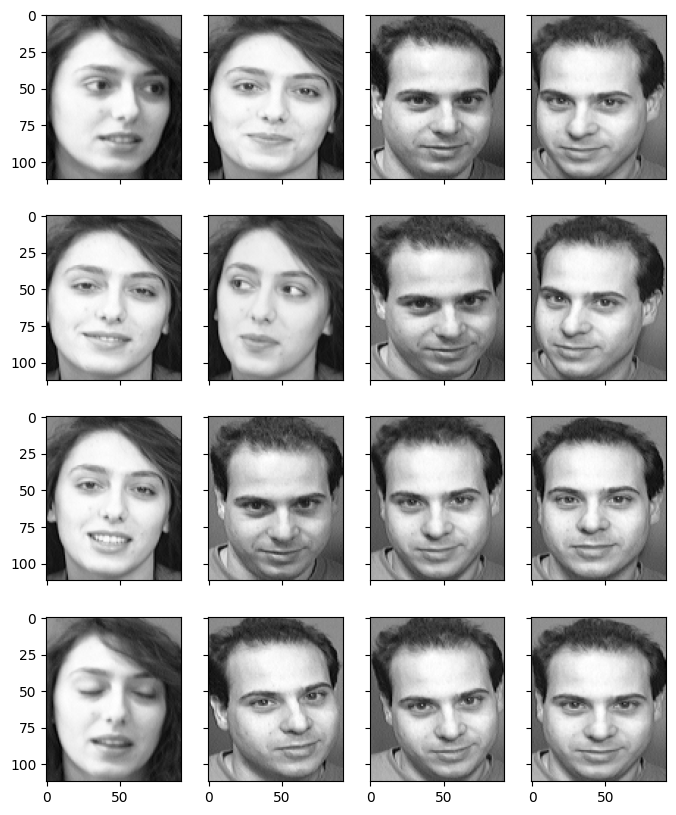

In [ ]:
## Show sample faces using matplotlib

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    ## what function to use to show image
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

In [ ]:
## Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

## The dimension of the feature space: 92
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400


In [ ]:
## Take classes 1-39 for eigenfaces, keep entire class 40 and
## image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

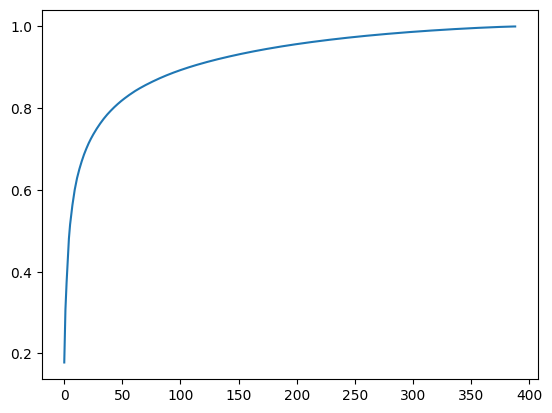

In [ ]:
## Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)

## Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
facematrix[0].shape

(10304,)

Showing the eigenfaces


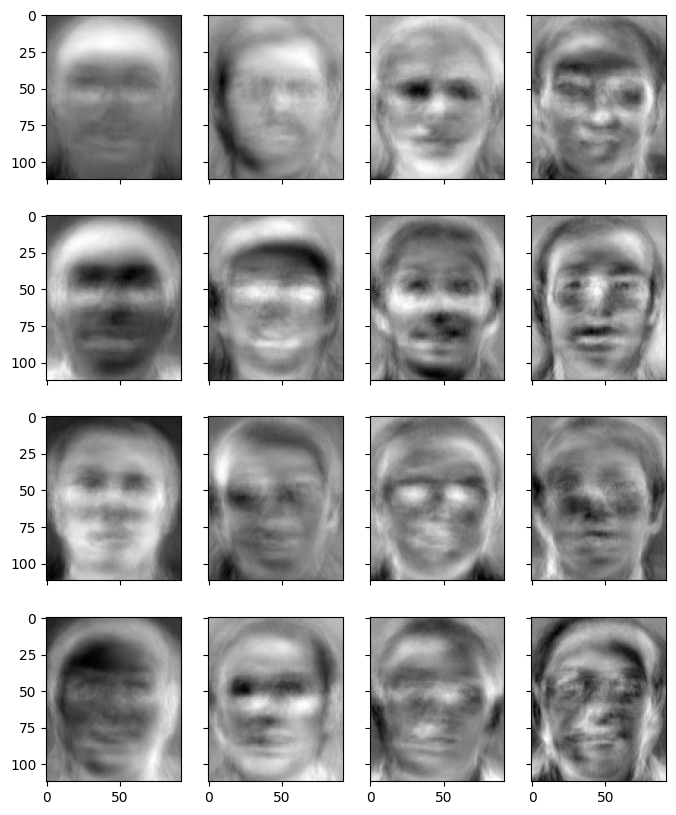

In [ ]:
n_components = 50

eigenfaces = pca.components_[:n_components]

## Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


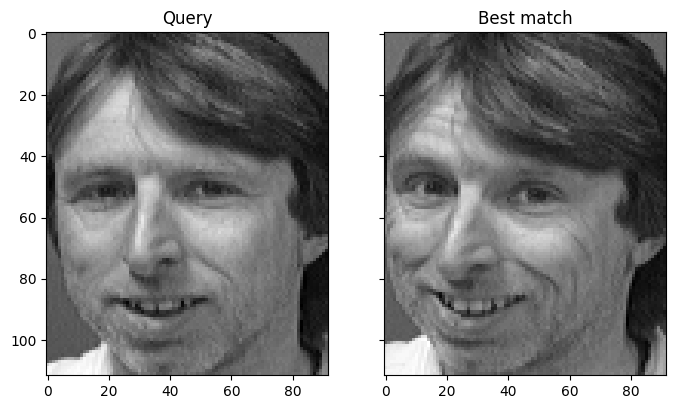

In [ ]:
## Generate weights as a KxN matrix where K is the number of eigenfaces
## and N the number of samples

## Since our goal is to build a face recognition system,
## we first calculate the weight vector for each input
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

## Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query -pca.mean_) .T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

## Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Best match s5 with Euclidean distance 2690.209330


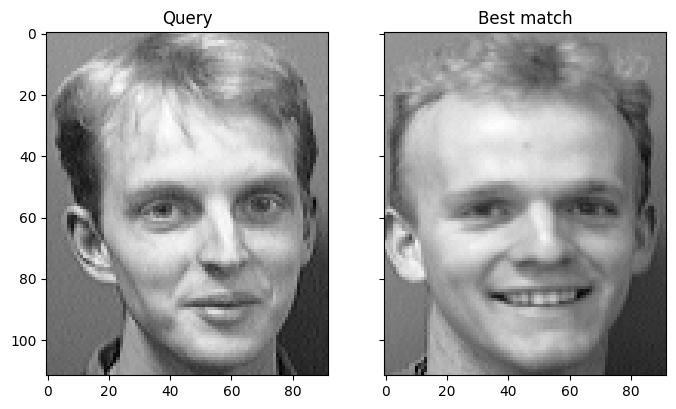

In [ ]:
## Out of Sample test
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

## Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Showing sample faces


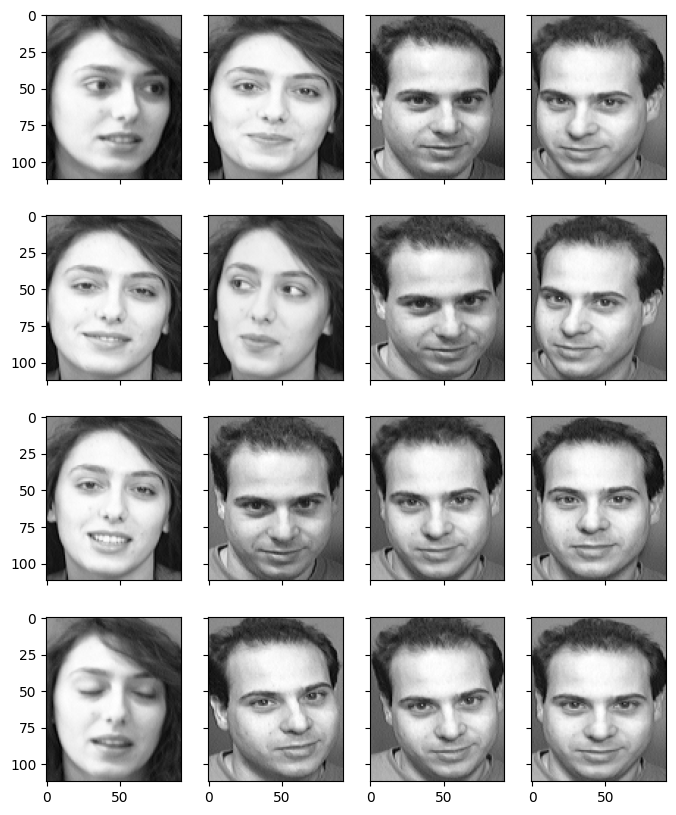

In [ ]:
## Show the last 16 original images again for comparison
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

In [ ]:
## Reconstruction code
## Project data to PCA and do the reconstruction

## Fit a PCA with 50 components
pcaNew = PCA(50)

## Fit the model with facematrix and apply the dimensionality reduction on facematrix.
X_proj = pcaNew.fit_transform(facematrix)

## Transform data back to its original space.
X_inv_proj = pcaNew.inverse_transform(X_proj)

## Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # plot the faces, each image is 64 by 64 dimension but 8x8 pixels for i in range(64): ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) ax.imshow(X_proj_img[i], cmap=plt.cm.bone, interpolation='nearest') - See more at: https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.5rN3fqhp.dpuf

## Reshape the image data into multiple dimensional array
X_proj_img = np.reshape(X_inv_proj,(X_inv_proj.shape[0],
                                    faceshape[0],faceshape[1]))

<Figure size 800x800 with 0 Axes>

Showing sample faces


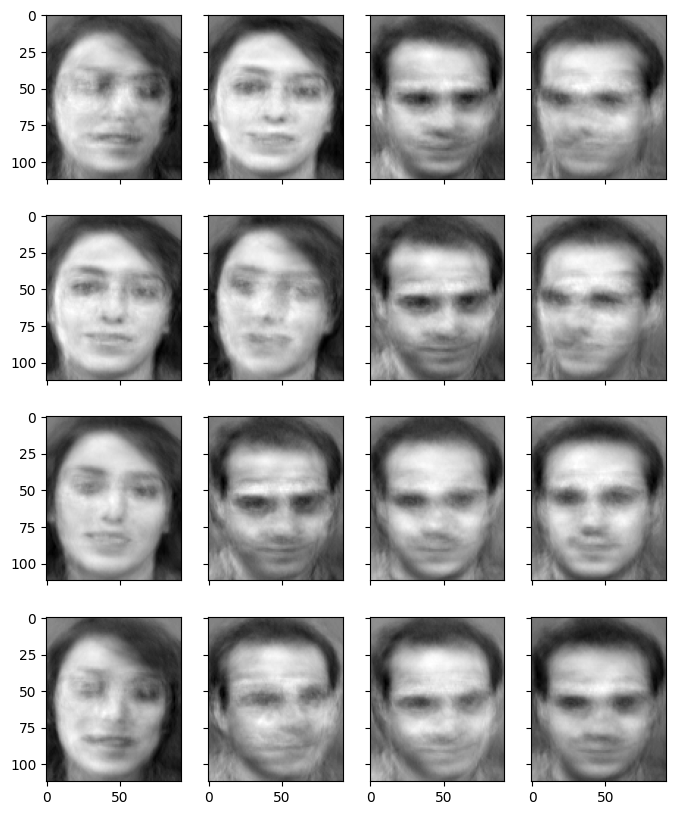

In [ ]:
## Show the last 16 reconstructed images
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
projimages = X_proj_img[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(projimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

Showing sample faces


<Figure size 800x800 with 0 Axes>

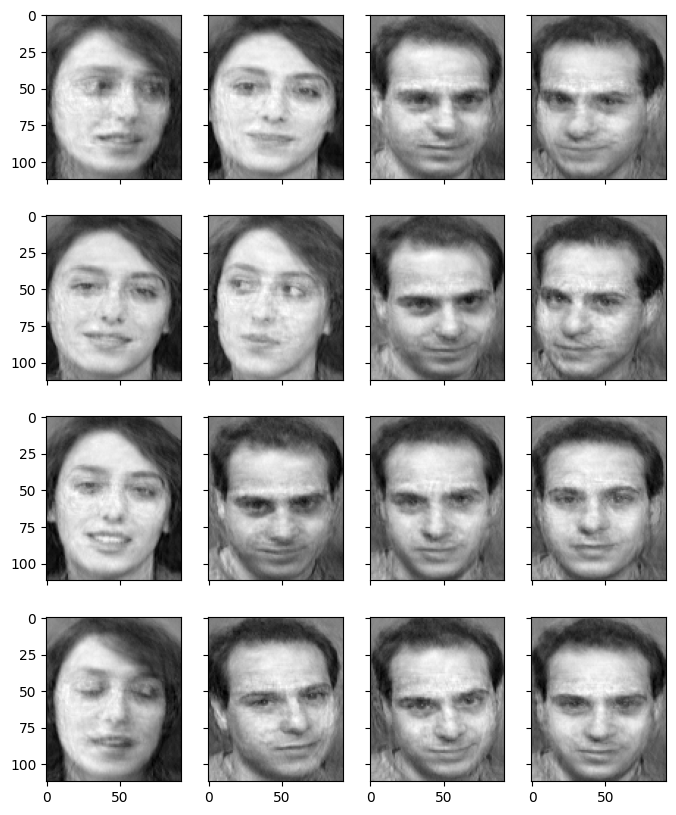

In [ ]:
## Increase the principle component number from 50 to 200
## And recheck the reconstruction quality

## Fit a PCA with 200 components
pcaNew1 = PCA(200)

## Fit the model with facematrix and apply the dimensionality reduction on facematrix.
X_proj1 = pcaNew1.fit_transform(facematrix)

## Transform data back to its original space.
X_inv_proj1 = pcaNew1.inverse_transform(X_proj1)

## Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # plot the faces, each image is 64 by 64 dimension but 8x8 pixels for i in range(64): ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) ax.imshow(X_proj_img[i], cmap=plt.cm.bone, interpolation='nearest') - See more at: https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.5rN3fqhp.dpuf

## Reshape the image data into multiple dimensional array
X_proj_img1 = np.reshape(X_inv_proj1,(X_inv_proj1.shape[0],
                                    faceshape[0],faceshape[1]))

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
projimages1 = X_proj_img1[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(projimages1[i], cmap="gray")
print("Showing sample faces")
plt.show()